In [16]:
print(__doc__)

# Author: Yea-Lee Lee <yealee.lee@gmail.com>
#

import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import copy
import math
import sys
import scipy.signal
import pickle
from joblib import dump, load


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from elements import ELEMENTS
from feature2 import construct_feature
from gbrtmodel import gbrt
from myfunction import my_range
from util import cut_feature
from util import calculate_ZT
from util import draw_pickup
from util import define_category




measureset=['electrical_conductivity','seebeck_coeff','thermal_conductivity']



column=['id','direction','temp','temp**1.5','1/temp',\
          'vbm_e','vbm_e2','vbm_e3',\
          'cbm_e','cbm_e2','cbm_e3','magnetism','deep_level',\
          'vbm_org_1', 'vbm_org_2','vbm_org_3','cbm_org_1','cbm_org_2','cbm_org_3',\
          'vbm_m','vbm_m2','vbm_m3','cbm_m','cbm_m2','cbm_m3',\
          'vbm_e_sn','vbm_e2_sn','vbm_e3_sn','cbm_e_sn','cbm_e2_sn','cbm_e3_sn',\
          'vbm_e_se','vbm_e2_se','vbm_e3_se','cbm_e_se','cbm_e2_se','cbm_e3_se',\
          'vbm_m_sn', 'vbm_m2_sn','vbm_m3_sn','cbm_m_sn','cbm_m2_sn','cbm_m3_sn',\
          'vbm_m_se', 'vbm_m2_se','vbm_m3_se','cbm_m_se','cbm_m2_se','cbm_m3_se',\
        'bandgap','bandgap_sn', 'bandgap_se', 'bandgap_rate',\
          'ion','covalent','vdw','atomic_radius','pauling_en','en_allen','polarizability','melting_point',\
          'boiling_point','density','specific_heat','thermal_conductivity',\
        'Sn_ratio','Se_ratio','Na_ratio','Cl_ratio','dopant_num', 'dopant_ratio']  

features=['vbm_e','vbm_e2','vbm_e3',\
          'cbm_e','cbm_e2','cbm_e3','magnetism','deep_level',\
          'vbm_org_1', 'vbm_org_2','vbm_org_3','cbm_org_1','cbm_org_2','cbm_org_3',\
          'vbm_m','vbm_m2','vbm_m3','cbm_m','cbm_m2','cbm_m3',\
        'vbm_e_sn','vbm_e2_sn','vbm_e3_sn','cbm_e_sn','cbm_e2_sn','cbm_e3_sn',\
          'vbm_e_se','vbm_e2_se','vbm_e3_se','cbm_e_se','cbm_e2_se','cbm_e3_se',\
          'vbm_m_sn', 'vbm_m2_sn','vbm_m3_sn','cbm_m_sn','cbm_m2_sn','cbm_m3_sn',\
          'vbm_m_se', 'vbm_m2_se','vbm_m3_se','cbm_m_se','cbm_m2_se','cbm_m3_se',\
          'vbm_ordering','cbm_ordering', 'vbm_org_ordering','cbm_org_ordering',\
          'vbm_sn_ordering','cbm_sn_ordering','vbm_se_ordering','cbm_se_ordering',\
          'bandgap','bandgap_sn', 'bandgap_se', 'bandgap_rate',\
          'ion','covalent','vdw','atomic_radius','pauling_en','en_allen','polarizability','melting_point',\
          'boiling_point','density','specific_heat','thermal_conductivity']

feature=['direction','temp',\
          'magnetism','deep_level',\
         'vbm_org_1', 'vbm_org_2','vbm_org_3','cbm_org_1','cbm_org_2','cbm_org_3',\
          'vbm_m','vbm_m2','vbm_m3','cbm_m','cbm_m2','cbm_m3',\
          'vbm_e_sn','vbm_e2_sn','vbm_e3_sn','cbm_e_sn','cbm_e2_sn','cbm_e3_sn',\
          'vbm_e_se','vbm_e2_se','vbm_e3_se','cbm_e_se','cbm_e2_se','cbm_e3_se',\
          'vbm_m_sn', 'vbm_m2_sn','vbm_m3_sn','cbm_m_sn','cbm_m2_sn','cbm_m3_sn',\
          'vbm_m_se', 'vbm_m2_se','vbm_m3_se','cbm_m_se','cbm_m2_se','cbm_m3_se',\
          'bandgap','bandgap_sn', 'bandgap_se', 'bandgap_rate',\
          'ion','covalent','vdw','atomic_radius','pauling_en','en_allen','polarizability','melting_point',\
          'boiling_point','density','specific_heat','thermal_conductivity',\
          'Sn_ratio','Se_ratio','Na_ratio','Cl_ratio','dopant_num', 'dopant_ratio']


numrow=0
ids=0

starttemp  = 300
endtemp    = 820
steptemp   = 20



######################## input from webpage ###################################
element_list=[ 'Zn', 'As']  #'Cd', 'Ge',
alloyingratio=[ 1, 1] #unit % #2.3, 3,
vacancyratio=[0,0] #2.9,0,
######################## input from webpage ###################################


#construct list of atomic compositions 
csvfile1='web_test_0_list_construct.csv'

with open(csvfile1,"w") as output1: #, open(csvfile2,"w") as output2, open(csvfile3,"w") as output3:
    writer1 = csv.writer(output1, lineterminator='\n')
    writer1.writerow(["","ID","Sn_ratio","Se_ratio","dopant1_num","dopant1_ratio","dopant2_num","dopant2_ratio",\
                      "dopant3_num","dopant3_ratio","direction","Temp","category"])    

    for alloyingatom, vacancy, ii in zip(element_list, vacancyratio, alloyingratio):

        
        jj= ii+vacancy
        x_trial=[] 
        y_fitted=[]

        for direction in [0]:
                
            for i in my_range(starttemp,endtemp,steptemp): #input of temperature data
                    
                #Na case      
                composition= [numrow,'TY'+str("{0:0=4d}".format(ids)),(1-jj*0.01)*0.99,1,\
                           ELEMENTS[alloyingatom].number,ii*0.01,11,0.01,0,0,direction,i]
                

                        
                        
                define_category(composition)
                writer1.writerow(composition)
                numrow+=1
            ids+=1
                 
                
    for alloyingatom, vacancy, ii in zip(element_list, vacancyratio, alloyingratio):

        
        jj= ii+vacancy
        x_trial=[] 
        y_fitted=[]

        for direction in [0]:
                
            for i in my_range(starttemp,endtemp,steptemp): #input of temperature data
                    
                #without Na case      
                
                composition= [numrow,'TY'+str("{0:0=4d}".format(ids)),1-jj*0.01,1,\
                                ELEMENTS[alloyingatom].number,ii*0.01,0,0,0,0,direction,i]
                        
                        
                define_category(composition)
                writer1.writerow(composition)
                numrow+=1
            ids+=1                
                


Automatically created module for IPython interactive environment


In [17]:
# construct feature vectors
cal =pd.read_excel('Results_Summary_Final.xlsx',index_col=0)
calnum=np.zeros((cal.shape[0],cal.shape[1]))
calnum = cal.values

thermo  = pd.read_csv(csvfile1, index_col=0)
test_data_x = construct_feature(thermo,calnum,features, False)
output=pd.DataFrame(test_data_x)
output.columns=column
output.to_csv('web_test_1.csv')
print('write complete Na', ids)


write complete Na 4


In [18]:
#load ML models and predict
measureset=['electrical_conductivity','seebeck_coeff','thermal_conductivity']
fold=5
iii=0

nTest=thermo.shape[0]
predicted=np.zeros((len(measureset),nTest))


for measure in measureset:
    testin=cut_feature(column,feature, test_data_x)
   
    for kkk in range(fold):
        
        filename = str(measure) + '_'+str(kkk)+'_'+'seed_'+str(0)+".joblib"
        
        clf = load(filename)
        predicted[iii,:] += clf.predict(testin)
    iii+=1

   
predicted /= fold
temp = thermo.Temp
ZT=calculate_ZT(predicted,temp,0,thermo, False, 'web_test_2_zt_search.csv')
el_cond=thermo.el_cond
seebeck=thermo.seebeck
thermal=thermo.thermal

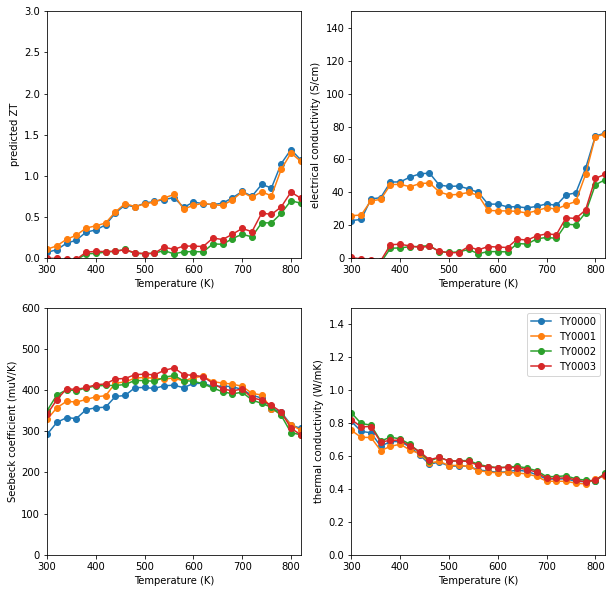

Na 0.01, Sn0.980 Zn 0.010 Se 1 : Max ZT=1.320
Na 0.01, Sn0.980 As 0.010 Se 1 : Max ZT=1.278
Sn0.990 Zn 0.010 Se 1 : Max ZT=0.699
Sn0.990 As 0.010 Se 1 : Max ZT=0.804


In [23]:
#################### output webpage ############################
draw_pickup(thermo,ZT,el_cond,seebeck,thermal,'Na')
i=0

for doping in element_list:
    ztlist=list()
    for temp in my_range(starttemp,endtemp,steptemp):
        ztlist.append(ZT[i])
        i=i+1
    
    
    print('Na 0.01,', 'Sn{0:.3f}'.format(thermo["Sn_ratio"][i-1]),\
           str(ELEMENTS[thermo["dopant1_num"][i-1]].symbol),'{0:.3f}'.format(thermo["dopant1_ratio"][i-1]), "Se",\
           thermo["Se_ratio"][i-1],':',\
           'Max ZT={0:.3f}'.format(max(ztlist)))
    
for doping in element_list:
    ztlist=list()
    for temp in my_range(starttemp,endtemp,steptemp):
        ztlist.append(ZT[i])
        i=i+1
    
    
    print('Sn{0:.3f}'.format(thermo["Sn_ratio"][i-1]),\
           str(ELEMENTS[thermo["dopant1_num"][i-1]].symbol),'{0:.3f}'.format(thermo["dopant1_ratio"][i-1]), "Se",\
           thermo["Se_ratio"][i-1],':',\
           'Max ZT={0:.3f}'.format(max(ztlist)))    
#################### output webpage ############################